In [ ]:
!pip install NRCLex

In [1]:
import json
import nltk
import random
import string
from datetime import datetime
from concurrent.futures import ThreadPoolExecutor, as_completed

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.corpus import wordnet as wn
from nltk.corpus import sentiwordnet as swn
from textblob import TextBlob
from deep_translator import GoogleTranslator
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.cluster import DBSCAN
from sklearn.decomposition import LatentDirichletAllocation, PCA
from sklearn.model_selection import GridSearchCV
from nrclex import NRCLex

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

<div style="background-color: lightblue; padding: 10px;">
    <h2 style="font-size: 18px; font-weight: bold;">Analyzing word frequency in own downloaded Facebook comments (in Latvian and English) using NLTK</h2>
</div>

In [ ]:
# Using a pre-trained tokenizer like Punkt is more efficient than writing own logic for sentence segmentation with punctuattion, capitalization etc.
nltk.download('punkt')  # For tokenization
nltk.download('stopwords')  # For stop words
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('vader_lexicon')
nltk.download('sentiwordnet')

In [2]:
# Download own Facebook activity from Facebook settings as a JSON file and open the file using utf-8 encoding
with open('C:\\Users\\thesk\\eclipse-workspace\\FBcomments.json', 'r', encoding='utf-8') as f:
    dataset = json.load(f)

In [ ]:
# The downloaded Facebook file will have the following format:
{"comments_v2": [
    { "timestamp": 1238254140,
      "data": [
        {"comment": {
                "timestamp": 1238254140,
                "comment": "N\u00c4\u0093 nu v\u00c4\u0081ks visp\u00c4\u0081r, cik da\u00c5\u00bei cilv\u00c4\u0093ki ir smuki :)",
                "author": "SKK"
          }}],
      "title": "SKK commented on ALR's photo."
    },

In [3]:
# Accessing the value associated with the key "comments_v2"
comment_blocks = dataset['comments_v2']
print("Number of comment blocks:", len(comment_blocks))

# Facebook file ""N\u00c4\u0093 nu v\u00c4\u0081ks visp\u00c4\u0081r, cik da\u00c5\u00bei cilv\u00c4\u0093ki ir smuki :)"
# is read in Jupyter notebook as 'NÄ\x93 nu vÄ\x81ks vispÄ\x81r, cik daÅ¾i cilvÄ\x93ki ir smuki :)'
# The Unicode escape sequences as \u00C4\u0093 are improperly interpreted and decoded, leading to the "garbled" characters like Ä\x93.
first_comment = dataset['comments_v2'][0]['data'][0]['comment']
print(f"Latvian/first comment: {first_comment['comment']}")

Number of comment blocks: 788
Latvian/first comment: NÄ nu vÄks vispÄr, cik daÅ¾i cilvÄki ir smuki :)


In [7]:
# Sample:
# 'cilv\u00c4\u0093ki'.encode('latin1').decode('utf-8')
# Output: cilvēki

# Function to replace all escaped Unicode sequences
def decode_unicode(text):
    # Encode the text to bytes, then decode it back
    return text.encode('latin1').decode('utf-8')

# Extract and decode comments
# from the JSON data by iterating each comment block in "comments_v2" as named in the Facebook download,
# extract the comment, and append it to a list called comments.
# c['data'][0] extracts the first comment object from the list of comments,
# (as each block contains only one comment, accessing the first element effectively retrieves the first and only comment within that block)
# and then ['comment'] accesses the "comment" key within that comment object to get the actual comment text, not a dictionary.

comments = []
for c in dataset['comments_v2']:
    comment = c['data'][0]['comment']['comment']
    # Decode escaped Unicode sequences
    decoded_comment = decode_unicode(comment)
    comments.append(decoded_comment)

# Now the comments should be properly decoded
print(comments[:1])

['Nē nu vāks vispār, cik daži cilvēki ir smuki :)']


In [8]:
# Tokenize the text
# ' '.join(comments) joins all comments into a single long string to be given as arg to word_tokenize
tokens = nltk.word_tokenize(' '.join(comments))

# Convert words to lowercase
tokens = [word.lower() for word in tokens]

# Remove punctuation with the str.maketrans() function to create a translation table that removes punctuation characters.
# The translate() method is then applied to each token to remove punctuation.
table = str.maketrans('', '', string.punctuation)
tokens = [word.translate(table) for word in tokens]

In [9]:
# No Latvian stop words available as of yet
from nltk.corpus import stopwords
print(stopwords.fileids())

['arabic', 'azerbaijani', 'basque', 'bengali', 'catalan', 'chinese', 'danish', 'dutch', 'english', 'finnish', 'french', 'german', 'greek', 'hebrew', 'hinglish', 'hungarian', 'indonesian', 'italian', 'kazakh', 'nepali', 'norwegian', 'portuguese', 'romanian', 'russian', 'slovene', 'spanish', 'swedish', 'tajik', 'turkish']


In [10]:
# Remove stop words
stop_words_english = set(nltk.corpus.stopwords.words('english'))
# Doesn't exist   stop_words_latvian = set(nltk.corpus.stopwords.words('latvian'))
# Latvian stop-word list taken from https://github.com/stopwords-iso/stopwords-lv/blob/master/stopwords-lv.txt
stop_words_latvian = ['aiz','ap','apakš','apakšpus','ar','arī','augšpus','bet','bez','bija','biji','biju','bijām','bijāt',
'viņus', 'viņām', 'mūs', 'mums', 'jūs', 'jums','aiz','ap','apakš','apakšpus','ar','arī','augšpus','bet','bez','bija','biji','biju','bijām','bijāt',
'būs','būsi','būsiet','būsim','būt','būšu','caur','diemžēl','diezin','droši','dēļ','esam','esat','esi','esmu','gan','gar','iekam','iekams','iekām',
'iekāms','iekš','iekšpus','ik','ir','it','itin','iz','ja','jau','jeb','jebšu','jel','jo','jā','ka','kamēr','kaut','kolīdz','kopš','kā','kļuva','kļuvi',
'kļuvu','kļuvām','kļuvāt','kļūs','kļūsi','kļūsiet','kļūsim','kļūst','kļūstam','kļūstat','kļūsti','kļūstu','kļūt','kļūšu','labad','lai','lejpus',
'līdz','līdzko','ne','nebūt','nedz','nekā','nevis','nezin','no','nu','nē','otrpus','pa','par','pat','pie','pirms','pret','priekš','pār','pēc','starp',
'tad','tak','tapi','taps','tapsi','tapsiet','tapsim','tapt','tapāt','tapšu','taču','te','tiec','tiek','tiekam','tiekat','tieku','tik','tika','tikai','tiki','tikko','tiklab','tiklīdz',                            
'tiks','tiksiet','tiksim','tikt','tiku','tikvien','tikām','tikāt','tikšu','tomēr','topat','turpretim','turpretī','tā','tādēļ','tālab','tāpēc','un','uz',
'vai','var','varat','varēja','varēji','varēju','varējām','varējāt','varēs','varēsi','varēsiet','varēsim','varēt','varēšu','vien','virs','virspus','vis','viņpus','zem','ārpus','šaipus']                            

stop_words = stop_words_english.union(stop_words_latvian)
stop_words.update(['http', 'https','«', '»', 'nt',' ',''])  # Add "http" etc. to the list

filtered_tokens = [word for word in tokens if word not in stop_words]

# Get the total count of tokens
print(len(filtered_tokens))

# Get a random sample of 30 tokens
sample_tokens = random.sample(filtered_tokens, 30)
print(sample_tokens)

5690
['albuumaa', 'personal', 'autisms', 'military', 'said', 'skin', 'little', 'use', 'areca', 'proven', 'vakar', 'zvaigzne', 'perhaps', 'dzīvoju', 'let', 'fb', 'wow', 'tev', 'talent', 'vēl', 'lapu', 'savās', 'president', 'talents', 'malchick', 'šo', 'tiešām', 'piedāvāt', 'akcentu', 'together']


In [11]:
# Lemmatize the tokens
# Create a lemmatizer object
lemmatizer = WordNetLemmatizer()

def get_wordnet_pos(treebank_tag):
    """Maps NLTK POS tags to WordNet POS tags.
    Args:
        treebank_tag: The NLTK POS tag.
    Returns:
        The corresponding WordNet POS tag or a default POS tag ('n').
    """
    if treebank_tag.startswith('J'):
        return nltk.corpus.wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return nltk.corpus.wordnet.VERB
    elif treebank_tag.startswith('N'):
        return nltk.corpus.wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return nltk.corpus.wordnet.ADV
    else:
        # Handle unknown POS tags gracefully with default POS tag (noun)
        return 'n'
    

def lemmatize_tokens(tokens):
    """Lemmatizes a list of tokens, handling POS tags.
    Args:
        tokens: The list of tokens to lemmatize.
    Returns:
        A list of lemmatized words.
    """
    # Get POS tags for each word
    pos_tags = nltk.pos_tag(tokens)

    # Lemmatize words based on POS tags
    lemmas = []
    for word, pos in pos_tags:
        lemma = lemmatizer.lemmatize(word, pos=get_wordnet_pos(pos))
        lemmas.append(lemma)

    return lemmas

# Lemmatize the filtered tokens
lemmas = lemmatize_tokens(filtered_tokens)

paldies 47
like 33
would 24
great 23
look 22
thank 22
see 21
well 20
go 20
know 20
say 19
one 19


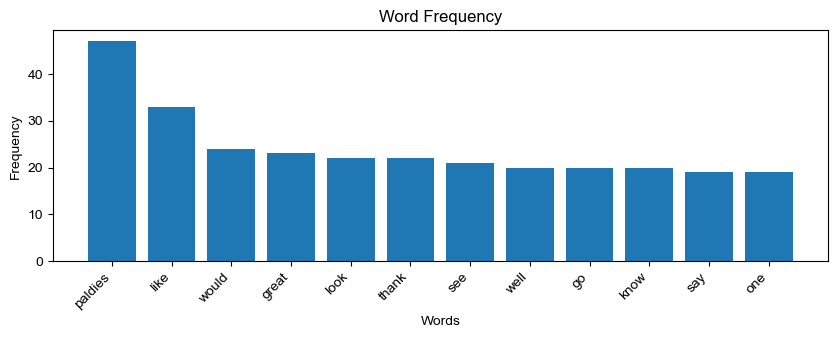

In [12]:
# Get the most common words and store as a list of tuples
most_common_words = nltk.FreqDist(lemmas).most_common(12)
    
# Extract words and frequencies from most_common_words
words = [word_tuple[0] for word_tuple in most_common_words]
frequencies = [word_tuple[1] for word_tuple in most_common_words]

for word, frequency in most_common_words:
    print(word, frequency)

# Create the bar chart
plt.rcParams['font.family'] = 'Arial'
plt.figure(figsize=(10, 3))
plt.bar(words, frequencies)
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.title('Word Frequency')
plt.xticks(rotation=45, ha='right')
plt.show()

<div style="background-color: lightblue; padding: 10px;">
    <h3 style="font-size: 18px; font-weight: bold;">Try TextBlob, a python library for processing textual data</h3>
</div>

In [58]:
# Replace the custom lemmatization function with TextBlob's built-in lemmatization capabilities
def lemmatize_tokens(tokens):
    
    lemmas = []
    for word in tokens:
        lemma = TextBlob(word).words[0].lemma
        lemmas.append(lemma)

    return lemmas

# Lemmatize the filtered tokens
lemmas = lemmatize_tokens(filtered_tokens)

# Get the most common words and store as a list of tuples
word_freq = nltk.FreqDist(lemmas)
most_common_words = word_freq.most_common(12)

for word, frequency in most_common_words:
    print(word, frequency)

thank 62
like 56
one 37
would 33
beautiful 30
look 30
great 29
also 23
well 22
know 22
said 21
thanks 21


#### The results seem about the same as with the custom lemmatization function.

<div style="background-color: lightgray; padding: 10px;">
    <h3 style="font-size: 18px; font-weight: bold;">Use Google Translator to first translate all comments from Latvian to English as preprocessing</h3>
</div>

In [59]:
translator = GoogleTranslator(source='lv', target='en')

def translate_comment(comment):
    """A function to translate a single comment and keep the timestamp."""
    try:
        # Access the comment text and timestamp
        translated_text = translator.translate(comment['data'][0]['comment']['comment'])
        timestamp = comment['data'][0]['comment']['timestamp']
        return translated_text, timestamp  # Return both translated text and timestamp
    except Exception as e:
        print(f"Translation failed for comment: {comment['data'][0]['comment']['comment']}")
        return None  # Return None if translation fails

# Translate comments with preserved timestamps
with ThreadPoolExecutor(max_workers=8) as executor:
    translated_comments_with_timestamps = list(executor.map(translate_comment, dataset['comments_v2']))

# Remove None values to filter out failed translations
translated_comments_with_timestamps = [entry for entry in translated_comments_with_timestamps if entry]

# Separate translated comments and timestamps for analysis and visualization
translated_comments_clean, timestamps = zip(*translated_comments_with_timestamps)

# Ensure translated_comments_clean only contains strings (filter out any remaining None values)
translated_comments_clean = [comment for comment in translated_comments_clean if comment is not None]

Years after translation: [2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023, 2024]


In [63]:
print(f"Number of comments in the translated list: {len(translated_comments_clean)}")

unique_original = len(set(comments))
unique_translated = len(set(translated_comments_clean))
print(f"Unique in original: {unique_original}, Unique in translated: {unique_translated}")

Number of comments in the translated list: 785
Unique in original: 737, Unique in translated: 707


#### Continue with the rest of NLP tasks (tokenization, stop words removal, etc.) as done above but now with translated comments in English

In [64]:
# Tokenize
tokens = nltk.word_tokenize(' '.join(translated_comments_clean))

# Convert words to lowercase
tokens = [word.lower() for word in tokens]

# Remove punctuation
table = str.maketrans('', '', string.punctuation)
tokens = [word.translate(table) for word in tokens]

# Remove stop words
stop_words = stopwords.words('english')
stop_words.extend(['http', 'https', 'www','com','«', '»', 'nt', ' ', ''])

filtered_tokens = [word for word in tokens if word not in stop_words]
print(f"Filtered tokens: {len(filtered_tokens)}")

# Lemmatize the tokens
lemmatizer = WordNetLemmatizer()

def get_wordnet_pos(treebank_tag):
    if treebank_tag.startswith('J'):
        return nltk.corpus.wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return nltk.corpus.wordnet.VERB
    elif treebank_tag.startswith('N'):
        return nltk.corpus.wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return nltk.corpus.wordnet.ADV
    else:
        return 'n'

def lemmatize_tokens(tokens):
    pos_tags = nltk.pos_tag(tokens)

    lemmas = []
    for word, pos in pos_tags:
        lemma = lemmatizer.lemmatize(word, pos=get_wordnet_pos(pos))
        lemmas.append(lemma)

    return lemmas

# Lemmatize the filtered tokens
lemmas = lemmatize_tokens(filtered_tokens)

# Get the most common words and store as a list of tuples
word_freq = nltk.FreqDist(lemmas)
most_common_words = word_freq.most_common(12)

for word, frequency in most_common_words:
    print(word, frequency)

Filtered tokens: 5315
thank 69
like 51
look 41
one 38
would 36
say 34
beautiful 33
great 28
think 28
see 28
good 26
go 25


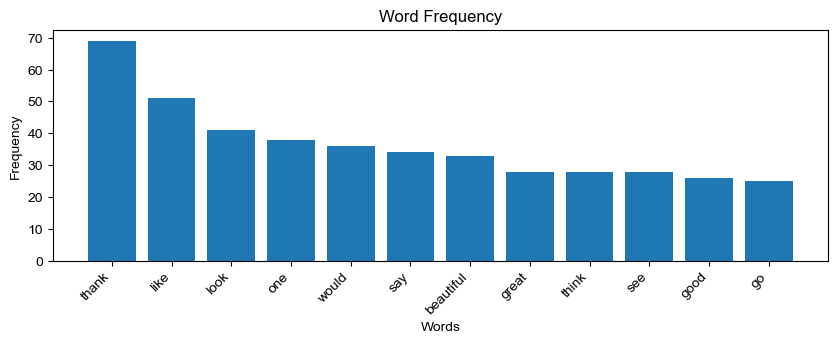

In [65]:
# Extract words and frequencies from most_common_words
words = [word_tuple[0] for word_tuple in most_common_words]
frequencies = [word_tuple[1] for word_tuple in most_common_words]

# Create the bar chart
plt.rcParams['font.family'] = 'Arial'
plt.figure(figsize=(10, 3))
plt.bar(words, frequencies)
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.title('Word Frequency')
plt.xticks(rotation=45, ha='right')
plt.show()

47 Paldies and 22 Thank are now properly counted as 69 Thank you prhases.

<div style="background-color: lightblue; padding: 12px;">
    <h3 style="font-size: 18px; font-weight: bold;">Sentiment Analysis</h3>
</div>

<div style="background-color: lightgray; padding: 7px;">
    <h4 style="font-size: 18px; font-weight: bold;">TextBlob polarity score</h4>
</div>

In [66]:
# Let's analyze polarity and sentiment. Polarity indicates how positive or negative the text is, -1 being the text is negative and +1 the most positive.
# Subjectivity analyzes how objective or subjective a text is from 0–1 respectively.
TextBlob(str(translated_comments_clean)).sentiment

Sentiment(polarity=0.26403565986804994, subjectivity=0.5715816283389805)

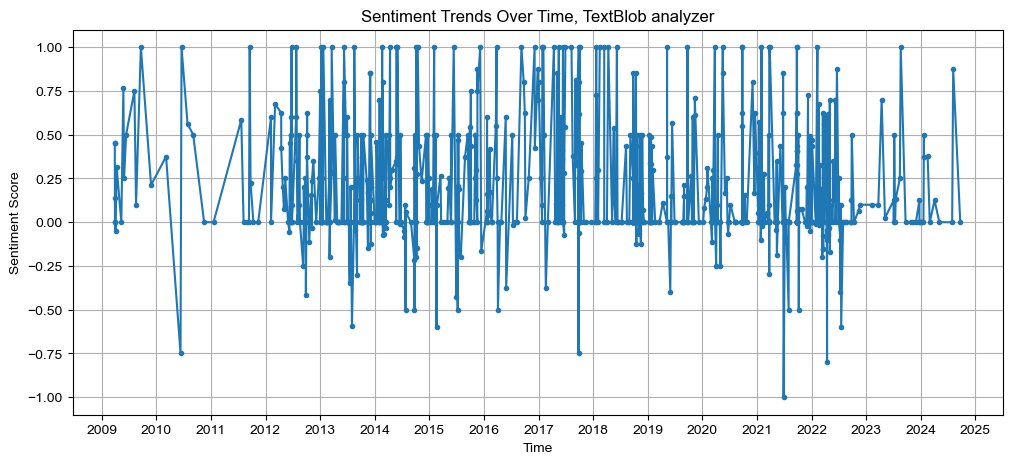

In [68]:
# Extract sentiment scores (TextBlob(comment).sentiment.polarity) and timestamps
sentiment_data = [
    (TextBlob(translated_comment).sentiment.polarity, original_comment['data'][0]['comment']['timestamp'])
    for translated_comment, original_comment in zip(translated_comments_clean, dataset['comments_v2'])]

# Convert timestamps to datetime objects
sentiment_data = [(sentiment, datetime.fromtimestamp(timestamp)) for sentiment, timestamp in sentiment_data]

# Unzip sentiment_data for plotting
sentiment_scores, timestamps = zip(*sentiment_data)

# Plot sentiment scores over time
plt.figure(figsize=(12, 5))
plt.plot(timestamps, sentiment_scores, marker='o', markersize=3)

# Format the x-axis to show years (e.g., 2010, 2011, etc.)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.gca().xaxis.set_major_locator(mdates.YearLocator())

plt.xlabel('Time')
plt.ylabel('Sentiment Score')
plt.title('Sentiment Trends Over Time, TextBlob analyzer')
plt.grid(True)
plt.show()

<div style="background-color: lightgray; padding: 7px;">
    <h4 style="font-size: 18px; font-weight: bold;">VADER sentiment analyzer</h4>
</div>

A handsome son for such a beautiful mother. {'neg': 0.0, 'neu': 0.36, 'pos': 0.64, 'compound': 0.7964}


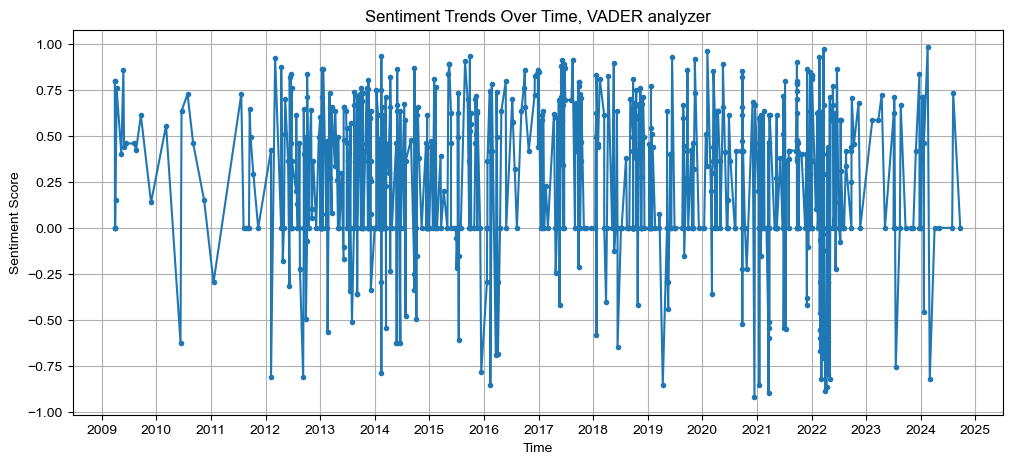

In [70]:
analyzer = SentimentIntensityAnalyzer()

# Print the first comment with its sentiment scores for score format demonstration
for comment in translated_comments_clean[:1]:
    sentim = analyzer.polarity_scores(comment)
    print(comment, sentim)

# Extract sentiment scores and timestamps for VADER
sentiment_data = [
    (analyzer.polarity_scores(translated_comment)['compound'], original_comment['data'][0]['comment']['timestamp'])
    for translated_comment, original_comment in zip(translated_comments_clean, dataset['comments_v2'])
]

# Convert timestamps to datetime objects
sentiment_data = [(sentiment, datetime.fromtimestamp(timestamp)) for sentiment, timestamp in sentiment_data]

# Unzip sentiment_data for plotting
sentiment_scores, timestamps = zip(*sentiment_data)

# Plot VADER sentiment scores over time
plt.figure(figsize=(12, 5))
plt.plot(timestamps, sentiment_scores, marker='o', markersize=3)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.xlabel('Time')
plt.ylabel('Sentiment Score')
plt.title('Sentiment Trends Over Time, VADER analyzer')
plt.grid(True)
plt.show()

<div style="background-color: lightgray; padding: 7px;">
    <h4 style="font-size: 18px; font-weight: bold;">Three sentiment analyzers, comparison</h4>
</div>

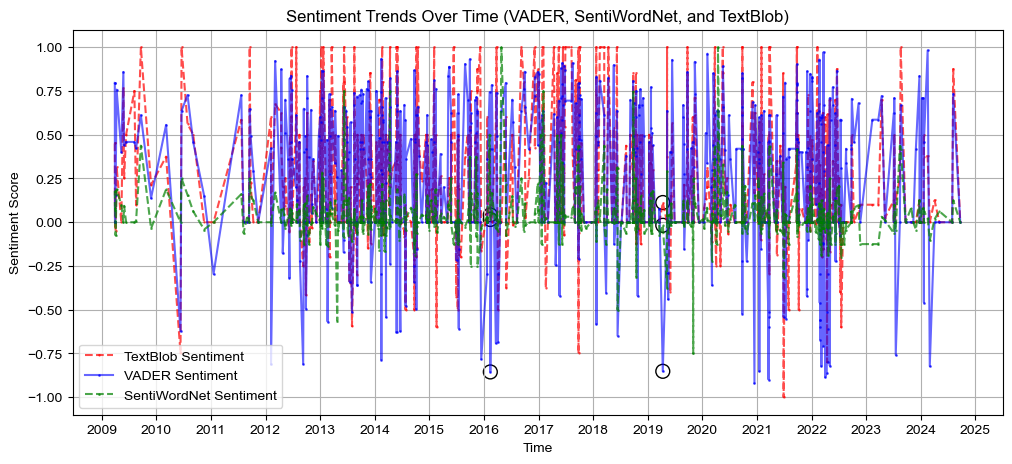

5 Most Negative Comments by VADER:
Score: -0.9201, Timestamp: 2020-12-14 18:57:02, Comment: Annie Studer These signatures are for a total ban in the entire country, then no one else will be able to buy it. "we call on the Saeima to adopt a ban on raising and killing animals in Latvia for the purpose of obtaining fur coats"
Score: -0.899, Timestamp: 2021-03-18 19:35:31, Comment: In relation to the minister who speaks to us, you can also try this: https://www.youtube.com/watch?v=-qjibYvrrDM  
04:20 You cannot be rejected ever, unless you give the person rejecting you permission to reject you. After all if I said to you, "Yeah, I just don't like you "'cause I don't like anyone who's got bright purple hair," you'd go, "Well, I don't have bright purple hair . "What are you talking about?"
You wouldn't let it in. But if I said, "I don't like you. "You're so boring. "There's nothing to you. "You're just dull and not very smart," you might let that in. You see how you have a choice? You get to

In [74]:
analyzer = SentimentIntensityAnalyzer()

sentiment_data = []
highlight_indices = []  # To store the indices of SPECIFIC comments (circles on chart)

for i, (translated_comment, original_comment) in enumerate(zip(translated_comments_clean, dataset['comments_v2'])):
    
    # TextBlob sentiment
    tb_sentiment = TextBlob(translated_comment).sentiment.polarity
    
    # VADER sentiment
    vader_sentiment = analyzer.polarity_scores(translated_comment)['compound']

    # SentiWordNet sentiment
    swn_sentiment_score = 0.0
    swn_word_count = 0  # Track the number of words with synsets
    words = nltk.word_tokenize(translated_comment.lower())
    for word in words:
        synsets = wn.synsets(word)
        if synsets:
            first_synset = synsets[0]
            swn_synset = swn.senti_synset(first_synset.name())
            swn_sentiment_score += swn_synset.pos_score() - swn_synset.neg_score()
            swn_word_count += 1
    
    # Normalize SentiWordNet score by the number of words with synsets
    if swn_word_count > 0:
        swn_sentiment_score /= swn_word_count
            
    # Extract timestamp
    timestamp = original_comment['data'][0]['comment']['timestamp']

    # Append three analyzers' scores along with timestamp and comment
    sentiment_data.append((vader_sentiment, swn_sentiment_score, tb_sentiment, datetime.fromtimestamp(timestamp), translated_comment))
    
    # Condition to check for specific phrases if interest arises in any specific comment
    if "anti-cancer" in translated_comment.lower() or "pollock would create layers" in translated_comment.lower():
        highlight_indices.append(i)  # Add index if the comment meets criteria


# Unzip sentiment_data for plotting
vader_scores, swn_scores, tb_scores, timestamps, _ = zip(*sentiment_data)

plt.figure(figsize=(12, 5))  # Plot three sentiment scores over time
vader_color = 'blue' # Define transparent colors, adjust alpha for transparency level
swn_color = 'green'
tb_color = 'red'
plt.plot(timestamps, tb_scores, marker='v', markersize=1, label='TextBlob Sentiment', color=tb_color, alpha=0.7, linestyle='--')
plt.plot(timestamps, vader_scores, marker='o', markersize=1, label='VADER Sentiment', color=vader_color, alpha=0.6)
plt.plot(timestamps, swn_scores, marker='^', markersize=1, label='SentiWordNet Sentiment', color=swn_color, alpha=0.7, linestyle='--')

# Highlight specific comments with circles
[plt.scatter(timestamps[index], score, s=100, edgecolor='black', facecolor='none', linewidth=1) 
 for index in highlight_indices 
 for score in (vader_scores[index], swn_scores[index], tb_scores[index])]

# Format the x-axis to show years (e.g., 2010, 2011, etc.)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.gca().xaxis.set_major_locator(mdates.YearLocator())

plt.xlabel('Time')
plt.ylabel('Sentiment Score')
plt.title('Sentiment Trends Over Time (VADER, SentiWordNet, and TextBlob)')
plt.legend()
plt.grid(True)
plt.show()


def find_most_negative(scores, num=5):
    """Find the 5 most negative scores for each analyzer"""
    return sorted(scores, key=lambda x: x[0])[:num]

# Extract scores for each analyzer
vader_scores = [(vader, timestamp, comment) for vader, _, _, timestamp, comment in sentiment_data]
swn_scores = [(swn, timestamp, comment) for _, swn, _, timestamp, comment in sentiment_data]
tb_scores = [(tb, timestamp, comment) for _, _, tb, timestamp, comment in sentiment_data]

# Find the 5 most negative scores
most_negative_vader = find_most_negative([(vader, timestamp, comment) for vader, _, _, timestamp, comment in sentiment_data])
most_negative_swn = find_most_negative([(swn, timestamp, comment) for _, swn, _, timestamp, comment in sentiment_data])
most_negative_tb = find_most_negative([(tb, timestamp, comment) for _, _, tb, timestamp, comment in sentiment_data])

# Print the results
print("5 Most Negative Comments by VADER:")
for score, timestamp, comment in most_negative_vader:
    print(f"Score: {score}, Timestamp: {timestamp}, Comment: {comment}")
print()
print("5 Most Negative Comments by SentiWordNet:")
for score, timestamp, comment in most_negative_swn:
    print(f"Score: {score}, Timestamp: {timestamp}, Comment: {comment}")
print()
print("5 Most Negative Comments by TextBlob:")
for score, timestamp, comment in most_negative_tb:
    print(f"Score: {score}, Timestamp: {timestamp}, Comment: {comment}")

<div style="background-color: lightgray; padding: 7px;">
    <h4 style="font-size: 18px; font-weight: bold;">Topic Modelling, DBSCAN</h4>
</div>

Number of unique TF-IDF vectors: 664
Total number of comments: 785
Cluster: 0
Comment: Picture perfect.. :)
Comment: Oh you sky, how beautiful!
Comment: There is something in this picture..
Comment: What a perfect evening it was!
Comment: Oh Robin, you are so nice!
Comment: That is such a beautiful picture!
Comment: Oh my.. :)
Comment: What a beautiful picture!
Comment: How beautiful!
Comment: Beautiful eyes..
Comment: Thanks for the picture!
Comment: Perfect picture and perfect title!
Comment: Oh, how cool!
Comment: How beautiful
Comment: From me too (at the cool picture)!
Comment: From me too! ð¹¹¹
Comment: The performances are beautiful!
Comment: Eyes like buttons
Comment: Greetings from me to the beautiful name and the beautiful host
Comment: What a cool picture!
Comment: Nature is so beautiful
Comment: Thank you, very beautiful! ð¹¹¹
Comment: Nature is an artist!
Comment: And the light is so perfect!
Comment: Very beautiful photo!


Cluster: 1
Comment: Happy birthday!
Comment: Hap

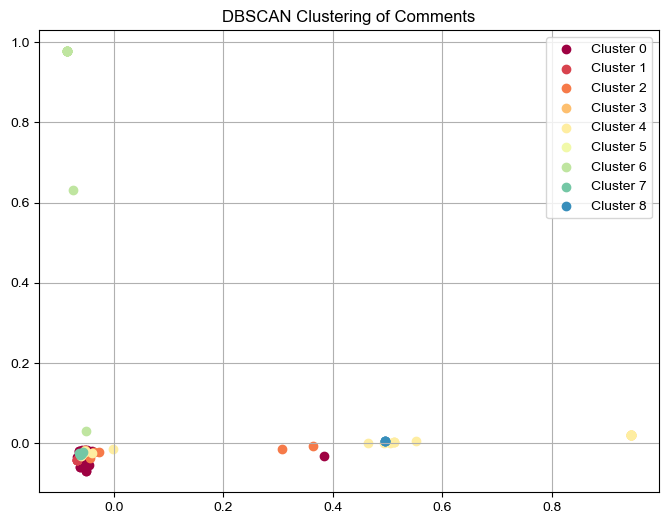

In [75]:
# Step 1: Convert the comments to TF-IDF vectors
vectorizer = TfidfVectorizer(stop_words='english')
X = vectorizer.fit_transform(translated_comments_clean)

# Check the number of unique vectors
unique_vector_count = np.unique(X.toarray(), axis=0).shape[0]
print(f"Number of unique TF-IDF vectors: {unique_vector_count}")
print(f"Total number of comments: {X.shape[0]}")

# Step 2: Apply DBSCAN to the TF-IDF vectorized comments
dbscan = DBSCAN(eps=0.5, min_samples=4, metric='cosine')
dbscan.fit(X)

# Step 3: Extract cluster labels
labels = dbscan.labels_

# Step 1: Create a dictionary to hold lists of comments for each cluster
clustered_comments = {}

# Populate the dictionary
for comment, label in zip(translated_comments_clean, labels):
    if label != -1:  # Skip noise comments
        if label not in clustered_comments:
            clustered_comments[label] = []
        clustered_comments[label].append(comment)

# Step 2: Print sorted comments by cluster
for label in sorted(clustered_comments.keys()):
    print(f"Cluster: {label}")
    for comment in clustered_comments[label]:
        print(f"Comment: {comment}")
    print("\n")  # Add an empty line between cluster printouts

# Optional: Plot the clustering results in 2D space (using PCA for dimensionality reduction)
# Reduce the dimensionality of the vectors to 2D for visualization
pca = PCA(n_components=2)
X_reduced = pca.fit_transform(X.toarray())

# Plot the comments in 2D space, coloring by cluster
plt.figure(figsize=(8, 6))
unique_labels = set(labels)
colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]

for label, color in zip(unique_labels, colors):
    if label == -1:
        continue  # Skip noise comments
    class_member_mask = (labels == label)
    xy = X_reduced[class_member_mask]
    plt.scatter(xy[:, 0], xy[:, 1], c=[color], label=f"Cluster {label}")

plt.title('DBSCAN Clustering of Comments')
plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.legend()
plt.grid(True)
plt.show()

The output shows that, after vectorizing with TF-IDF, only 605 of the 784 comments have unique vector representations, meaning that some comments have identical TF-IDF features, likely because of similar or highly overlapping terms. 

<div style="background-color: lightgray; padding: 7px;">
    <h4 style="font-size: 18px; font-weight: bold;">Topic Modelling, Latent Dirichlet Allocation (LDA)</h4>
</div>

In [78]:
# Vectorize the preprocessed comments
vectorizer = CountVectorizer(stop_words=stop_words, max_df=0.8, min_df=5, ngram_range=(1, 2))
X = vectorizer.fit_transform(translated_comments_clean)

# Function to calculate perplexity for different numbers of topics
def calculate_perplexity(num_topics_list, X):
    perplexities = []
    for num_topics in num_topics_list:
        lda = LatentDirichletAllocation(n_components=num_topics, random_state=0)
        lda.fit(X)
        perplexity = lda.perplexity(X)
        perplexities.append(perplexity)
        print(f"Number of topics: {num_topics}, Perplexity: {perplexity}")
    return perplexities

# Define the range of topics to evaluate
num_topics_list = [5, 10, 15, 20, 25, 30]

# Calculate perplexity for each number of topics
perplexities = calculate_perplexity(num_topics_list, X)

# Find the optimal number of topics (lowest perplexity)
optimal_num_topics = num_topics_list[np.argmin(perplexities)]
print(f"Optimal number of topics: {optimal_num_topics}")

# Fit the LDA model with the optimal number of topics
best_lda = LatentDirichletAllocation(n_components=optimal_num_topics, random_state=0)
best_lda.fit(X)

# Display the top words for each topic
words = vectorizer.get_feature_names_out()
num_words = 5
for topic_idx, topic in enumerate(best_lda.components_):
    print(f"Topic {topic_idx + 1}: ", " ".join([words[i] for i in topic.argsort()[:-num_words - 1:-1]]))

Number of topics: 5, Perplexity: 230.59558964613424
Number of topics: 10, Perplexity: 267.47873348585256
Number of topics: 15, Perplexity: 299.84810202498824
Number of topics: 20, Perplexity: 320.8408371291291
Number of topics: 25, Perplexity: 337.30330749347695
Number of topics: 30, Perplexity: 350.84990480708797
Optimal number of topics: 5
Topic 1:  like happy already let work
Topic 2:  would time latvia said right
Topic 3:  well great know thanks love
Topic 4:  thank one think even day
Topic 5:  beautiful much wow thank also


<div style="background-color: lightgray; padding: 7px;">
    <h4 style="font-size: 18px; font-weight: bold;">NRCLex, Emotion detection</h4>
</div>

NRCLex(or NRCLexicon) is an MIT-approved PyPI project by Mark M. Bailey which predicts the sentiments and emotion of a given text. The package contains approximately 27,000 words and is based on the National Research Council Canada (NRC) affect lexicon and the NLTK library’s WordNet synonym sets.

Emotional affects measured include: fear, anger, anticipation, trust, surprise, positive, negative, sadness, disgust, joy.

In [85]:
# Analyze emotions for each comment
emotions_list = [NRCLex(comment).top_emotions for comment in translated_comments_clean]

# Print emotions for the 6th comment (index 5)
if len(translated_comments_clean) > 5:
    fifth = translated_comments_clean[5]
    fifth_comment_emotions = emotions_list[5]
    print(f"Comment 5: {fifth_comment}\nTop Emotions: {fifth_comment_emotions}\n")
else:
    print("There are less than 5 comments in the list.")

Comment 4: People go crazy when they get to Bali :)
Top Emotions: [('fear', 0.25), ('anger', 0.25), ('negative', 0.25), ('sadness', 0.25)]



In [89]:
# Create a DataFrame with the emotions
df = pd.DataFrame({'comments': translated_comments_clean, 'emotions': emotions_list})

# Flatten the list of emotions
all_emotions = [emotion for sublist in df['emotions'] for emotion in sublist]
emotion_counts = Counter([emotion[0] for emotion in all_emotions])

# Convert to DataFrame for visualization
emotion_df = pd.DataFrame(emotion_counts.items(), columns=['Emotion', 'Count'])
print(emotion_df)

         Emotion  Count
0       positive    629
1            joy    503
2           fear    442
3          anger    413
4        anticip    380
5          trust    505
6       surprise    422
7       negative    485
8        sadness    420
9        disgust    406
10  anticipation    116


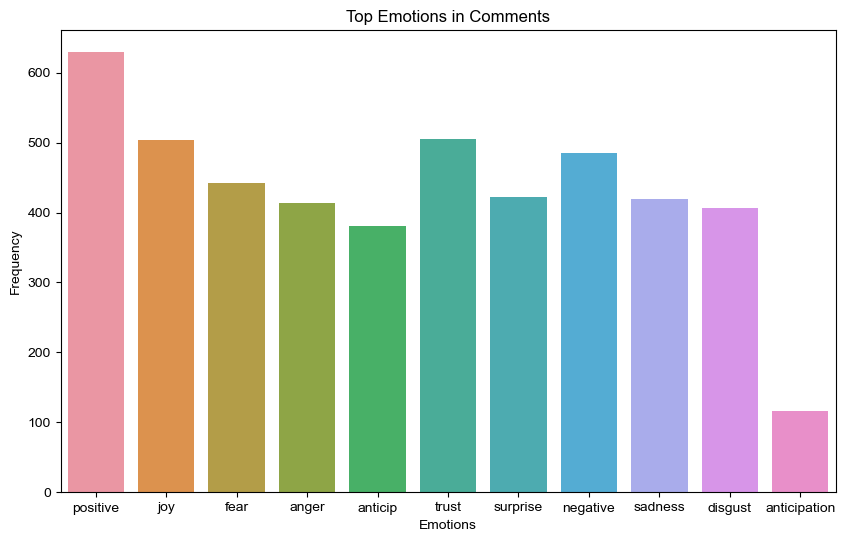

In [88]:
def analyze_comments(comments):
    data = []
    for comment in comments:
        emotion = NRCLex(comment).top_emotions
        data.append({'comment': comment, 'emotions': emotion})

    df = pd.DataFrame(data)
    all_emotions = [emotion for sublist in df['emotions'] for emotion in sublist]
    emotion_counts = Counter([emotion[0] for emotion in all_emotions])
    emotion_df = pd.DataFrame(emotion_counts.items(), columns=['Emotion', 'Count'])

    plt.figure(figsize=(10, 6))
    sns.barplot(x='Emotion', y='Count', data=emotion_df)
    plt.title('Top Emotions in Comments')
    plt.xlabel('Emotions')
    plt.ylabel('Frequency')
    plt.show()

analyze_comments(translated_comments_clean)